#### Data Download and Preprocessing
This notebook documents the workflow for downloading, cropping, and preparing data from Google Earth Engine (GEE) and other sources.  
The prepared rasters are saved for use in the classification step.


### Initial setup

In [ ]:
import ee
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio     
import numpy as np 
from rasterio.io import MemoryFile
from rasterio.transform import from_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
# connect to GEE
ee.Authenticate()
ee.Initialize(project = "ee-ogalloethel")

#### Define AOI and time range

In [3]:
# Base directory whee data is stored
base_dir = r"C:\Users\Ethel Ogallo\Documents\ZFL1\Data"

# Verify the directory exists
if not os.path.exists(base_dir):
    print(f"WARNING: Base directory does not exist: {base_dir}\nPlease check your path!")
else:
    print(f"Base directory found: {base_dir}")


# Set AOI from shapefile
shapefile = gpd.read_file(os.path.join(base_dir, 'baringo_bbox/baringo_bbox.shp'))
study_area = ee.Geometry(shapefile.geometry[0].__geo_interface__)


# Define time range
years = list(range(2015, 2026))

Base directory found: C:\Users\Ethel Ogallo\Documents\ZFL1\Data


#### Data download from GEE

##### Helper functions for data export 

In [ ]:
# Function to read a raster file and return an aligned array
def clip_to_aoi(image):
    """
    Clip an ee.Image to the study_area geometry.
    Args:
        image (ee.Image): The image to clip.
    Returns:   
        ee.Image: The clipped image.
        """
    if not isinstance(image, ee.Image):
        raise TypeError("Input must be an ee.Image")
    return image.clip(study_area)

# Function to export an ee.Image to Google Drive
def export_image_to_drive(image, year, label='image', folder='Exports', scale=30):
    """
    Export an ee.Image to Google Drive.
    Args:
        image (ee.Image): The image to export.
        year (int): The year associated with the image.
        label (str): A label for the exported image.
        folder (str): The folder in Google Drive to save the image.
        scale (int): The scale of the exported image in meters.
    Returns:
        None
    """
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=f'{label}_{year}',
        folder=folder,
        fileNamePrefix=f'{label}_{year}',
        scale=scale,
        region=study_area,
        fileFormat='GeoTIFF',
        maxPixels=1e13
    )
    task.start()
    print(f"Export started: {label}_{year}")



#### 1. DEM and Slope

In [ ]:
# Function to get DEM and slope
def get_dem():
    """
    Retrieve DEM and slope.

    Returns:
        Tuple[ee.Image, ee.Image]: (DEM image, slope image)
    """
    dem = ee.ImageCollection("COPERNICUS/DEM/GLO30") \
        .filterBounds(study_area).mosaic().select('DEM')
    dem = clip_to_aoi(dem).toFloat().reproject('EPSG:32736', 30)
    slope = ee.Terrain.slope(dem).rename('Slope')
    return dem.rename('DEM'), slope

# Get DEM and slope
dem, slope = get_dem()

# Export or process each as needed
export_image_to_drive(dem, year='DEM', label='DEM', folder='DEM')
export_image_to_drive(slope, year='Slope', label='Slope', folder='DEM')

#### 2. Land Surface Temperature

In [ ]:
# cloud masking
def cloud_mask(image):
    # Mask clouds and cloud shadows using QA_PIXEL band
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(1 << 3).eq(0).And(qa.bitwiseAnd(1 << 5).eq(0))
    return image.updateMask(mask)

# download data
def download_lst(year):
    """
    Download Landsat 8 LST for a specific year.
    Args:
        year (int): The year for which to download the LST image.
    Returns:
        ee.Image: The mean LST image for the specified year.
    """
    lst_col = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
               .filterBounds(study_area)
               .filterDate(f'{year}-01-01', f'{year}-12-31')
               .map(cloud_mask)
               .map(lambda img: img.select('ST_B10')
                    .multiply(0.00341802).add(149.0)
                    .subtract(273.15)
                    .rename('LST'))
               .map(clip_to_aoi))
    return lst_col.mean().set({'year': year})


# Loop through the years and export LST images
# Get the LST image for each year and export it to Google Drive
for year in years: 
    lst = download_lst(year)
    export_image_to_drive(lst, year, label='LST_mean', folder='LST')

#### 3. NDVI standard deviation and range 

In [ ]:
def compute_ndvi(year):
    """
    Compute NDVI for Sentinel-2 images for a specific year.
    Args:
        year (int): The year for which to compute NDVI.
    Returns:   
        ee.Image: The NDVI standard deviation and range for the specified year.
    """
    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda img: img.addBands(
              img.normalizedDifference(['B8', 'B4']).rename('NDVI')))
          .select('NDVI'))

    ndvi_std = s2.reduce(ee.Reducer.stdDev()).rename(f'NDVI_SD_{year}')
    ndvi_range = s2.reduce(ee.Reducer.max()).subtract(
        s2.reduce(ee.Reducer.min())
    ).rename(f'NDVI_Range_{year}')
    return ndvi_std, ndvi_range


# Export NDVI statistics to Google Drive
for year in years:
    ndvi_std, ndvi_range = compute_ndvi(year)
    export_image_to_drive(ndvi_std, year, label='NDVI_SD', folder='NDVI')
    export_image_to_drive(ndvi_range, year, label='NDVI_Range', folder='NDVI')


#### 4. NDWI max 

In [ ]:
def compute_ndwi(year):
    """
    Compute maximum NDWI for Sentinel-2 images for a given year.
    Args:
        year (int): Year of interest.
    Returns:
        ee.Image: Max NDWI image.
    """
    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda img: img.normalizedDifference(['B8', 'B3'])
               .rename('NDWI').toFloat()))
    return s2.max().rename(f'NDWI_Max_{year}')

# Export NDVI statistics 
for year in years:
    ndwi_max = compute_ndwi(year)
    export_image_to_drive(ndwi_max, year, label='NDWI_Max', folder='NDWI')

#### 5. S1 VV and VH GRD 

In [ ]:
def get_sentinel1_min(year, pol='VV', orbit_pass='ASCENDING'):
    """
    Get annual minimum Sentinel-1 backscatter (dB) for given polarization.

    Args:
        year (int): Year of interest.
        pol (str): Polarization ('VV' or 'VH').
        orbit_pass (str): Orbit pass ('ASCENDING' or 'DESCENDING').
    Returns:
        ee.Image: Minimum Sentinel-1 backscatter image for the specified year and polarization.
    """
    s1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filterBounds(study_area)
          .filter(ee.Filter.eq('instrumentMode', 'IW'))
          .filter(ee.Filter.eq('orbitProperties_pass', orbit_pass))
          .filter(ee.Filter.eq('resolution_meters', 10))
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', pol))
          .select(pol))
    return clip_to_aoi(s1.min().rename(f'S1_{pol}_Min_{year}'))


# Export Sentinel-1 VV and VH minimum backscatter images for each year
for year in years:
    for pol in ['VV', 'VH']:
        img = get_sentinel1_min(year, pol=pol)
        task = ee.batch.Export.image.toDrive(
            image=img,
            description=f'S1_{pol}_Min_{year}',
            folder=f'S1_{pol}',
            fileNamePrefix=f'S1_{pol}_Min_{year}',
            region=study_area,
            scale=10,
            crs='EPSG:4326',
            maxPixels=1e13
        )
        task.start()
        print(f"Started export: S1_{pol}_Min_{year}")


#### 6. EVI 

In [ ]:
def compute_evi(year):
    """
    Compute median EVI for Sentinel-2 images for a specific year.
    Args:
        year (int): The year for which to compute EVI.
    Returns:   
        ee.Image: Median EVI image for the specified year.
    """
    s2 = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
          .filterBounds(study_area)
          .filterDate(f'{year}-01-01', f'{year}-12-31')
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .map(clip_to_aoi)
          .map(lambda img: img.expression(
              '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
                  'NIR': img.select('B8').divide(10000), #scale 
                  'RED': img.select('B4').divide(10000),
                  'BLUE': img.select('B2').divide(10000)
              }).rename('EVI').float()))

    evi_median = s2.median().rename(f'EVI_Median_{year}')
    return evi_median


# Export EVI statistics to Google Drive
for year in years:
    evi_median = compute_evi(year)
    export_image_to_drive(evi_median, year, label='EVI_Median', folder='EVI')

#### Processing the data

#### crop all the datasets to the smaller extents

In [4]:
## using smaller extents
# Central point in decimal degrees
center_lat = 0.6
center_lon = 36.0667

# Define a bounding box: ±0.3° latitude (north-south), ±0.15° longitude (east-west)
lat_buffer = 0.3
lon_buffer = 0.15

# Compute extent (bounding box)
extent = (
    center_lon - lon_buffer,  # xmin (left)
    center_lat - lat_buffer,  # ymin (bottom)
    center_lon + lon_buffer,  # xmax (right)
    center_lat + lat_buffer   # ymax (top)
)

print("Computed extent:", extent)

Computed extent: (35.9167, 0.3, 36.216699999999996, 0.8999999999999999)


#### reproject the slope to env crs

In [ ]:
# Function to reproject a raster to match another raster's CRS and dimensions
def reproject_to_match(src_path, ref_path, dst_path):
    """
    Reproject a raster to match the CRS, transform, and shape of a reference raster.
    Args:
        src_path (str): Path to source raster.
        ref_path (str): Path to reference raster.
        dst_path (str): Path to save reprojected raster.
    """
    with rasterio.open(ref_path) as ref, rasterio.open(src_path) as src:
        dst_array = np.empty((ref.height, ref.width), dtype=src.dtypes[0])
        reproject(
            source=src.read(1),
            destination=dst_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref.transform,
            dst_crs=ref.crs,
            resampling=Resampling.bilinear
        )
        profile = src.profile.copy()
        profile.update({
            'crs': ref.crs,
            'transform': ref.transform,
            'width': ref.width,
            'height': ref.height
        })
        with rasterio.open(dst_path, 'w', **profile) as dst:
            dst.write(dst_array, 1)


# reroject
reproject_to_match(
    src_path=os.path.join(base_dir, 'DEM', 'Slope.tif'),
    ref_path=os.path.join(base_dir, 'DEM', 'DEM.tif'),
    dst_path=os.path.join(base_dir, 'DEM', 'Slope_aligned.tif')
)

In [ ]:
year = 2020

file_map = {
    "LST": os.path.join(base_dir, "LST", f"LST_mean_{year}.tif"),
    "NDWI": os.path.join(base_dir, "NDWI_1", f"NDWI_Max_{year}.tif"),
    "NDVI_SD": os.path.join(base_dir, "NDVI", f"NDVI_SD_{year}.tif"),
    "NDVI_range": os.path.join(base_dir, "NDVI", f"NDVI_Range_{year}.tif"),
    "EVI_Median": os.path.join(base_dir, "EVI", f"EVI_Median_{year}.tif"),
    "VV": os.path.join(base_dir, "S1_VV", f"S1_VV_Min_{year}.tif"),
    "VH": os.path.join(base_dir, "S1_VH", f"S1_VH_Min_{year}.tif"),
    "DEM": os.path.join(base_dir, "DEM", f"DEM.tif"),
    "Slope": os.path.join(base_dir, "DEM", f"Slope_aligned.tif"),
}

print(f"Raster shapes for year {year}:")
for name, path in file_map.items():
    if os.path.exists(path):
        with rasterio.open(path) as src:
            print(f"{name}: {src.shape}")
    else:
        print(f"{name}: MISSING ({path})")


In [5]:
# DEM and slope (static)
dem_path = os.path.join(base_dir, "input/DEM", "DEM.tif")
slope_path = os.path.join(base_dir, "input/DEM", "Slope_aligned.tif")

# Prepare output dictionary
cropped_rasters_by_year = {}

for year in range(2015, 2026):
    year_data = {}

    # Temporal rasters 
    file_map = {
        "LST": os.path.join(base_dir, "input/LST", f"LST_mean_{year}.tif"),
        "NDWI": os.path.join(base_dir, "input/NDWI_1", f"NDWI_Max_{year}.tif"),
        "NDVI_SD": os.path.join(base_dir, "input/NDVI", f"NDVI_SD_{year}.tif"),
        "NDVI_range": os.path.join(base_dir, "input/NDVI", f"NDVI_Range_{year}.tif"),
        "EVI_Median": os.path.join(base_dir, "input/EVI", f"EVI_Median_{year}.tif"),
        "VV": os.path.join(base_dir, "input/S1_VV", f"S1_VV_Min_{year}.tif"),
        "VH": os.path.join(base_dir, "input/S1_VH", f"S1_VH_Min_{year}.tif"),
    }

    for name, path in file_map.items():
        if not os.path.exists(path):
            print(f"Missing: {path}")
            continue
        with rasterio.open(path) as src:
            window = from_bounds(*extent, transform=src.transform)
            arr = src.read(1, window=window)
            year_data[name] = arr

    # Static rasters 
    for path, name in zip([dem_path, slope_path], ["DEM", "Slope"]):
        with rasterio.open(path) as src:
            window = from_bounds(*extent, transform=src.transform)
            arr = src.read(1, window=window)
            year_data[name] = arr


    # Save year if at least some data exists
    if len(year_data) > 0:
        cropped_rasters_by_year[year] = year_data
    else:
        print(f"No data stored for {year}")

print("Cropping complete.")


Cropping complete.


Resampling VV and VH data to match the shape of the rest of the raster data

In [ ]:
def resample_to_ref(src_arr, src_path, dst_shape, dst_transform, dst_crs):
    with rasterio.open(src_path) as src:
        src_transform = src.window_transform(
            from_bounds(*extent, transform=src.transform)
        )
        src_crs = src.crs
        dst_arr = np.empty(dst_shape, dtype=src_arr.dtype)

        reproject(
            source=src_arr,
            destination=dst_arr,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear,
        )
    return dst_arr


# Reference raster info (DEM)
with rasterio.open(dem_path) as dem_src:
    window = from_bounds(*extent, transform=dem_src.transform)
    dem_transform = dem_src.window_transform(window)
    dem_crs = dem_src.crs

for year in cropped_rasters_by_year:
    dem_arr = cropped_rasters_by_year[year]["DEM"]
    dst_shape = dem_arr.shape

    for pol in ["VV", "VH"]:
        if pol in cropped_rasters_by_year[year]:
            src_arr = cropped_rasters_by_year[year][pol]
            src_path = os.path.join(base_dir, f"input\S1_{pol}", f"S1_{pol}_Min_{year}.tif")

            resampled_arr = resample_to_ref(src_arr, src_path, dst_shape, dem_transform, dem_crs)
            cropped_rasters_by_year[year][pol] = resampled_arr

print("Resampling VV/VH complete.")


Resampling VV/VH complete.


#### save the processed raster data 

In [13]:
output_dir = os.path.join(base_dir, "processed_data/cropped_rasters")
os.makedirs(output_dir, exist_ok=True)

for year, rasters in cropped_rasters_by_year.items():
    year_out_dir = os.path.join(output_dir, str(year))
    os.makedirs(year_out_dir, exist_ok=True)

    for name, arr in rasters.items():
        out_path = os.path.join(year_out_dir, f"{name}.tif")
        if arr is None:
            print(f"Skipping missing array: {year} - {name}")
            continue

        with rasterio.open(
            out_path,
            "w",
            driver="GTiff",
            height=arr.shape[0],
            width=arr.shape[1],
            count=1,
            dtype=arr.dtype,
            crs=dem_crs,
            transform=dem_transform,
        ) as dst:
            dst.write(arr, 1)
    print(f"Saved rasters for year {year}")

Saved rasters for year 2015
Saved rasters for year 2016
Saved rasters for year 2017
Saved rasters for year 2018
Saved rasters for year 2019
Saved rasters for year 2020
Saved rasters for year 2021
Saved rasters for year 2022
Saved rasters for year 2023
Saved rasters for year 2024
Saved rasters for year 2025


#### Visualize the data

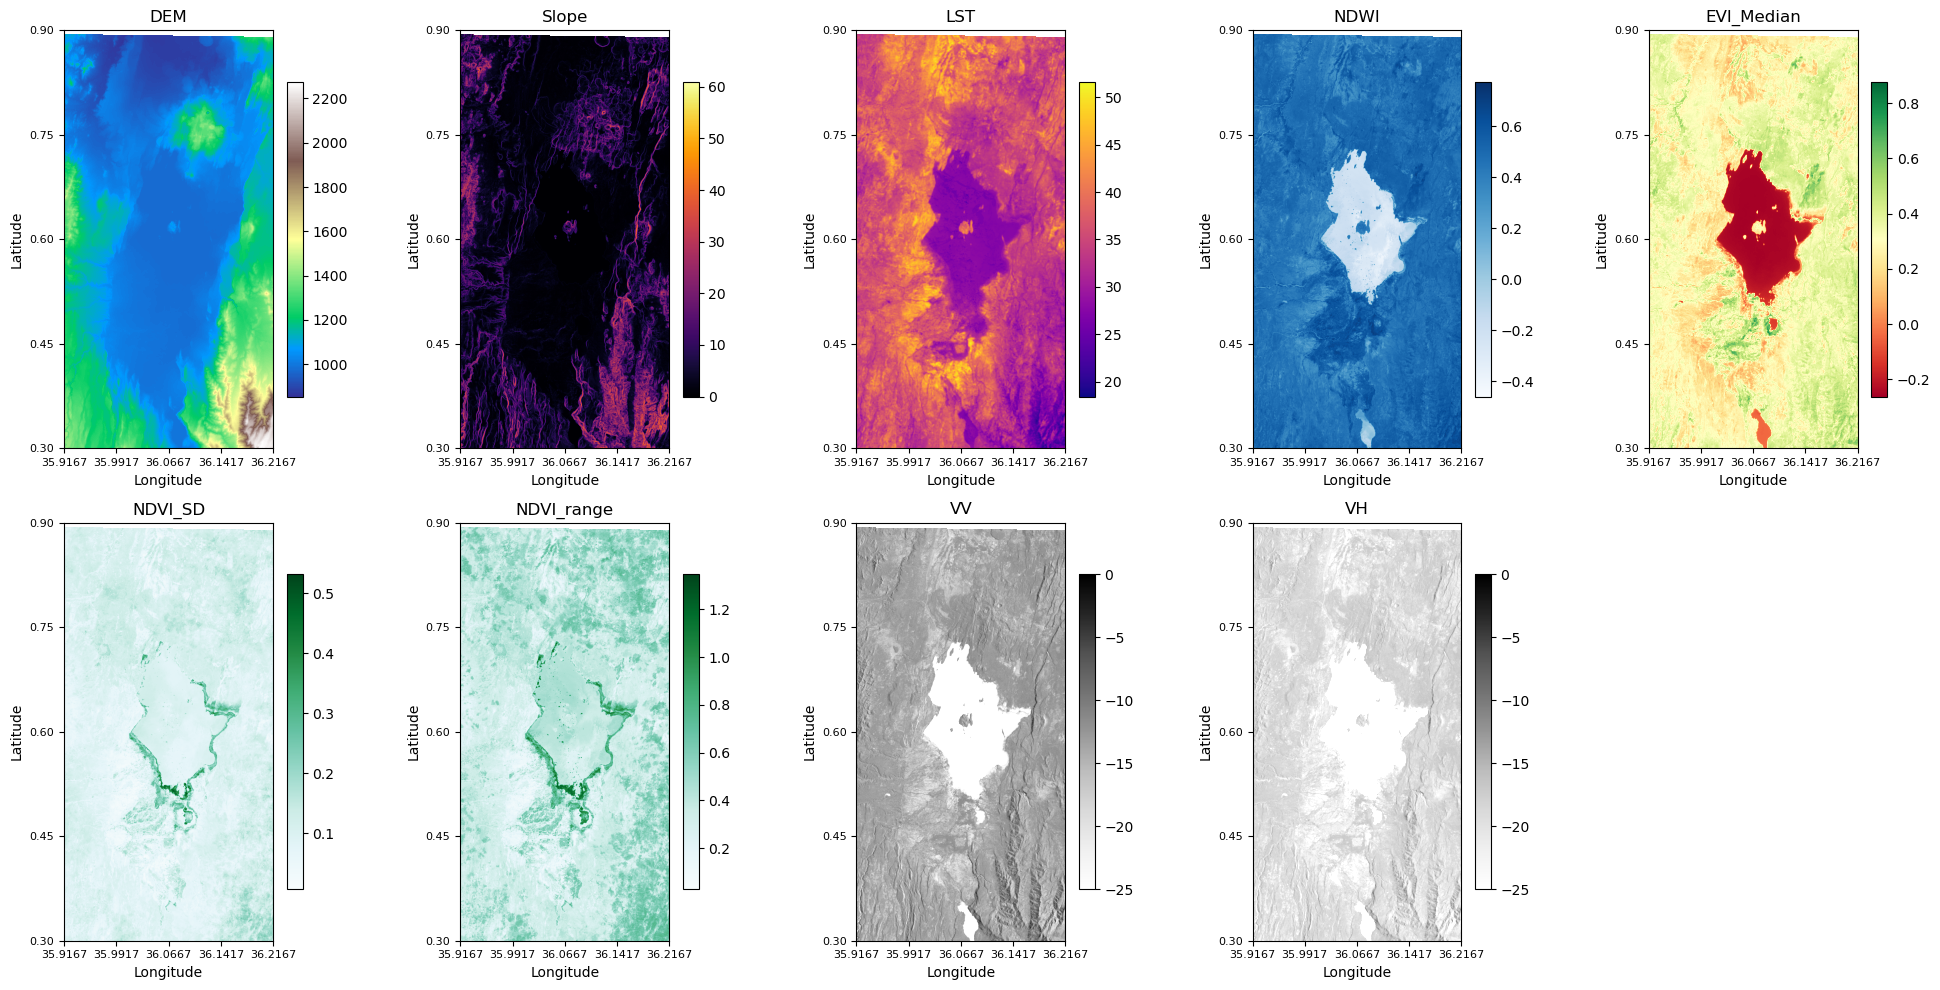

In [15]:

layers_to_plot = ["DEM", "Slope", "LST", "NDWI", "EVI_Median", "NDVI_SD","NDVI_range", "VV", "VH"]
 

# Load each raster into a dict
layer_data = {}
for name in layers_to_plot:
    path = os.path.join(output_dir, str(2020), f"{name}.tif")
    if os.path.exists(path):
        with rasterio.open(path) as src:
            layer_data[name] = src.read(1)
    else:
        print(f"Missing raster: {path}")

colormaps = {
    "DEM": "terrain", "Slope": "inferno", "LST": "plasma", "NDWI": "Blues",
    "NDVI_SD": "BuGn", "NDVI_range": "BuGn", "VV": "Greys", "VH": "Greys",
    "EVI_Median": "RdYlGn"
}

nrows = 2
ncols = -(-len(layers_to_plot) // nrows)  # ceiling division 
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 5 * nrows))
axes = axes.flatten()
xmin, ymin, xmax, ymax = extent

for ax, name in zip(axes, layers_to_plot):
    if name in layer_data:
        # For VV and VH, set color limits for dB range
        if name in ["VV", "VH"]:
            vmin, vmax = -25, 0  # typical SAR dB range, adjust if needed
            img = ax.imshow(layer_data[name], cmap=colormaps.get(name, "viridis"),
                            extent=[xmin, xmax, ymin, ymax], origin='upper',
                            vmin=vmin, vmax=vmax)
        else:
            img = ax.imshow(layer_data[name], cmap=colormaps.get(name, "viridis"),
                            extent=[xmin, xmax, ymin, ymax], origin='upper')
        
        ax.set_title(name)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

        xticks = np.linspace(xmin, xmax, 5)
        yticks = np.linspace(ymin, ymax, 5)
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.tick_params(axis='both', which='major', labelsize=8)

        fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
    else:
        ax.axis('off')
        print(f"{name} missing for 2020")


for ax in axes[len(layers_to_plot):]:
    ax.axis('off')

plt.tight_layout()
plt.show()
